In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [63]:
df = pd.read_csv("./data/titanic.csv")
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


### 不要カラムの削除

意味が重複するデータを削除。具体的には以下の通り

- who : 男性 or 女性 → sexと同じ
- adult_male : 成人であるかどうか → sex、ageから導出可能
- embark_town : 出港地 → embarkedと同じ
- alive : 生存したかどうか → survivedと同じ
- alone : 一人であったかどうか → sibsp, parchから導出可能

In [64]:
df = df.drop(['who', 'adult_male', 'embark_town', 'alive', 'alone'], axis=1)

### 非数値データを数値に変換

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
 8   class     891 non-null    object 
 9   deck      203 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB


In [66]:
# 数値に置き換え
encode_cols = ['sex', 'embarked', 'class', 'deck']
lbl = LabelEncoder()
for f in encode_cols:
    df[f] = lbl.fit_transform(list(df[f].values))

### 欠損値の補完

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  891 non-null    int64  
 8   class     891 non-null    int64  
 9   deck      891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


In [68]:
# 数値系データの欠損値を平均値で補完
encode_cols = ['age']
for f in encode_cols:
    df[f].fillna(df[f].mean(), inplace=True)

In [69]:
df.isnull().sum()

survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
class       0
deck        0
dtype: int64

In [70]:
X = df.drop(["survived"], axis=1)
y = df['survived'].values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Feature Importance による評価

Feature Importanceは、各特徴量の分類寄与率を評価する指標で、木構造のアルゴリズムの特性を生かした評価指標になります。
もう少し詳しくいうと、「ある特徴量で分割することでどれくらいジニ不純度を下げられるのか」ということになります。

In [72]:
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(y_pred[:10])
print(accuracy_score(y_test, y_pred))

[0 0 0 0 0 0 0 1 0 1]
0.7873134328358209


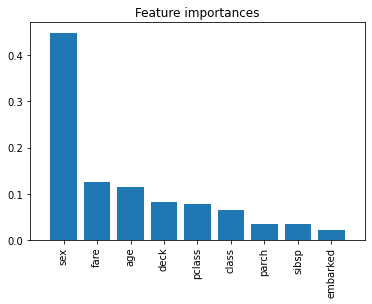

In [73]:
#重要度の可視化
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

### Permutation Importanceによる評価

Permutation Importanceは、「ある特徴量がどれだけモデルの予測精度向上に寄与しているのか」を評価する手法です。     
評価方法は非常にシンプルで、評価対象の特徴量をランダムに並べ替え、予測精度にどのくらい影響を出すかを評価します。     
(精度の低下が大きいほど予測に重要な特徴量といえる)

Permutation Importanceは、Feature Importanceと比較して以下のメリットがあります。

- 木構造のアルゴリズム以外で使える
- 学習データとテストデータに対して評価できる(Feature Importanceは、学習データを基準とした評価となる)
- 特徴量の算出方法が直感的

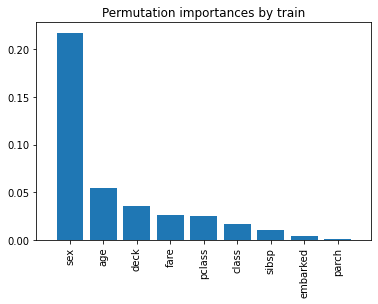

In [74]:
permutation_result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=0)
importances = permutation_result.importances_mean

indices = np.argsort(importances)[::-1]
plt.figure()
# Feature imporaneとの差分: グラフのタイトルをかえる
plt.title("Permutation importances by train") 
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

Permutation Importanceは各特徴量がどのくらい分類精度に貢献しているかを絶対評価で表します。
また、値がマイナスを出すこともあります。マイナスの場合は分類精度を下げる要因になっている可能性が高いということがいえます。

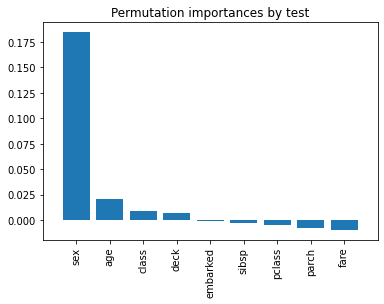

In [75]:
permutation_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0)
importances = permutation_result.importances_mean

indices = np.argsort(importances)[::-1]
plt.figure()
# タイトルをかえる
plt.title("Permutation importances by test")
plt.bar(range(X_test.shape[1]), importances[indices], align="center")
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation='vertical')
plt.xlim([-1, X_test.shape[1]])
plt.show()


fare は学習データに対してはプラスであるのにテストデータではマイナスの評価となっている。過学習を起こしている可能性あり

In [76]:
drop_list = ["fare"]
X_train_2 = X_train.drop(drop_list, axis=1)
X_test_2 = X_test.drop(drop_list, axis=1)

In [77]:
clf.fit(X_train_2, y_train)
y_pred = clf.predict(X_test_2)
print(accuracy_score(y_test, y_pred))

0.8059701492537313


学習データとテストデータで可視化を行い、傾向が似ていればOK